<a href="https://colab.research.google.com/github/otlvrzl/transfer_learning1/blob/main/TFH_transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Hub 
## Image Classification

This notebook is very similar to the example from Section 2 **Transfer Learning with a Pretrained ConvNet** except for the following:
* Dataset: the **Oxford Flowers 102** (instead of the tf_flowers dataset)
* Base model: MobileNet v2 from **TensorFlow Hub** (instead of tf.keras.applications)

In [1]:
# Enable TensorFlow 2.0
%tensorflow_version 2.x

In [2]:
# Import Tensorflow
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
# Install tfds-nightly so that we can download oxford_flowers102 version 2.1.0
!pip install tfds-nightly

     |████████████████████████████████| 4.2 MB 8.0 MB/s 
     |████████████████████████████████| 76 kB 2.4 MB/s 


In [4]:
# Import TensorFlow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Import Keras 
from tensorflow import keras

# Import TensorFlow Hub
import tensorflow_hub as hub

# Import Numpy
import numpy as np
import matplotlib.pyplot as plt

## Data pipeline

#### Load the dataset
OxFord Flowers 102 is one of the TensorFlow 2.0 datasets with 102 category of common flowers in UK.

In [6]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='oxford_flowers102:2.1.1',
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True)

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [7]:
num_classes = metadata.features['label'].num_classes
num_train =  len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_classes)
print("Number of training samples:", num_train)
print("Number of validation samples:",  num_validation)
print("Number of test samples:", num_test)

Number of classes: 102
Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [8]:
# Inspect datasets before data preprocessing
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [9]:
classlabel = metadata.features['label']
classlabel.get_serialized_info

<bound method Tensor.get_serialized_info of ClassLabel(shape=(), dtype=tf.int64, num_classes=102)>

In [10]:
classlabel

ClassLabel(shape=(), dtype=tf.int64, num_classes=102)

In [11]:
# Get labels / class names
class_names = np.array(metadata.features['label'].names)
class_names

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

### Visualize the data
Let's take a look a few of the flower images

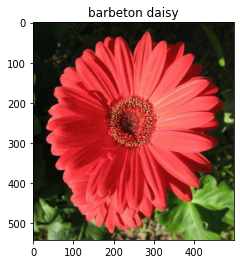

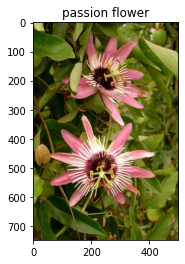

In [12]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[label])

### Image preprocessing

Resize, normalize, augment, shuffle and batch the data.

In [13]:
IMG_SIZE = 224 
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image/255.0
  return image, label

In [14]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [15]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [16]:
train = train.map(augment_data)

#### Shuffle and batch dataset

In [17]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [18]:
# Inspect datasets after data preprocessing
print(train_batches)
print(validation_batches)
print(test_batches)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [19]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Training


### Create the model

In [20]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape = IMG_SHAPE, trainable=False)

In [21]:
model = tf.keras.Sequential([feature_extractor_layer,  
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


### Compile the model

In [22]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

### Train the model

In [23]:
# Set training parameters
NUM_EPOCHS = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = round(num_validation)//BATCH_SIZE

In [24]:
history = model.fit(
    train_batches,
    epochs=NUM_EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_batches,
    validation_steps=validation_steps)

Epoch 1/10
192/192 [==============================] - 56s 205ms/step - loss: 2.3349 - accuracy: 0.4998 - val_loss: 1.2393 - val_accuracy: 0.7379
Epoch 2/10
192/192 [==============================] - 42s 218ms/step - loss: 0.9332 - accuracy: 0.8010 - val_loss: 0.8060 - val_accuracy: 0.8145
Epoch 3/10
192/192 [==============================] - 41s 214ms/step - loss: 0.7002 - accuracy: 0.8499 - val_loss: 0.6659 - val_accuracy: 0.8458
Epoch 4/10
192/192 [==============================] - 39s 203ms/step - loss: 0.5931 - accuracy: 0.8720 - val_loss: 0.5664 - val_accuracy: 0.8750
Epoch 5/10
192/192 [==============================] - 39s 203ms/step - loss: 0.4943 - accuracy: 0.8990 - val_loss: 0.5119 - val_accuracy: 0.8760
Epoch 6/10
192/192 [==============================] - 43s 223ms/step - loss: 0.4690 - accuracy: 0.8964 - val_loss: 0.4695 - val_accuracy: 0.8851
Epoch 7/10
192/192 [==============================] - 42s 217ms/step - loss: 0.4101 - accuracy: 0.9106 - val_loss: 0.4512 - val_ac

In [25]:
# Display training curves
def display_training_curves(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.plot(epochs_range, acc, label='Train accuracy')
  plt.plot(epochs_range, val_acc, label='Val accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show()

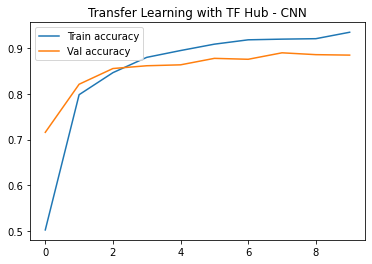

<Figure size 432x288 with 0 Axes>

In [ ]:
# Display training curve 
display_training_curves(history, "Transfer Learning with TF Hub - CNN")

### Test accuracy

In [26]:
# Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8500000238418579


## Visualize predictions

In [27]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]

Then we visualize some of the images and compare whether the predicted labels equal to the true labels. 

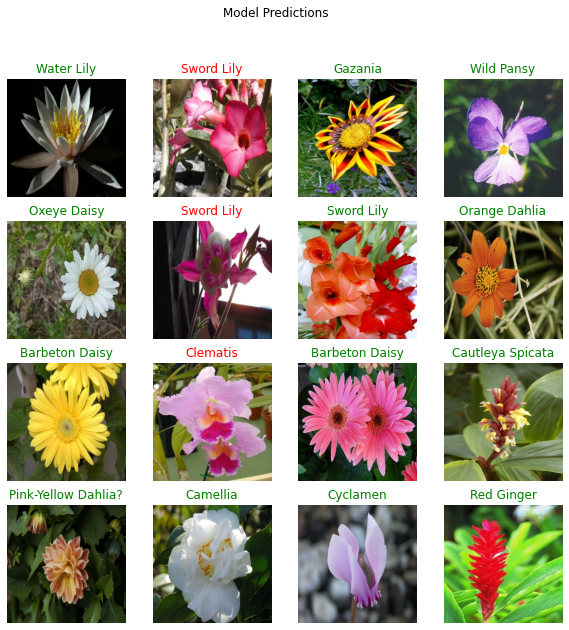

In [29]:
plt.figure(figsize=(10, 10))

# Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i+1)
  # Display each image
  plt.imshow(image_batch[i])
  # Set title color: green if prediction correct and red if prediction incorrect
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')

_ = plt.suptitle("Model Predictions")